# Trading Strategy (Unsupervised Learning)

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [2]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956310   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZION      1420600.0  
           ZTS       1007200.0  

[994508 rows x 6 columns]

## Calculating features and technical indicators for each stock

In [3]:
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134434   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977476   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956310   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     125.359324  
           AAL          NaN       NaN       NaN       NaN     470.599859  
           AAPL         NaN       NaN       NaN       NaN    6488.247492  
           ABBV         NaN       NaN       NaN       NaN     420.356642  
           ABT          NaN       NaN       NaN       NaN     451.883284  
...                     ...       ...       ...       ...            ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  0.784240     156.373892  
           ZBH     4.784470  4.815377 -1.054422  0.973531     103.396317  
           ZBRA    5.546306  5.676707 -0.154931  1.577769      68.687826  
           ZION    3.749483  3.887381  0.177122  2.099563      62.321720  
           ZTS     5.259449  5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

<Axes: xlabel='date'>

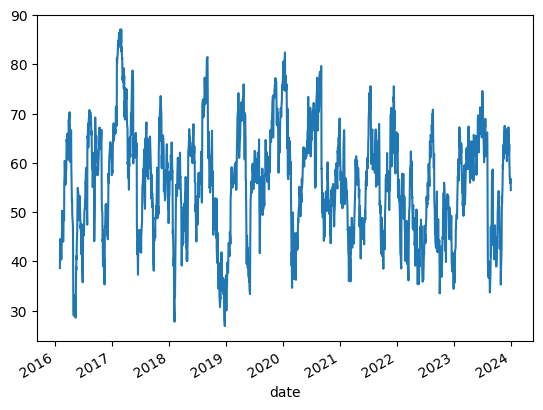

In [4]:
df.xs('AAPL', level = 1)['rsi'].plot()

## Filtering top 150 most liquid stocks for each month

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A           91.918049   35.004200         -0.001914  48.107903   
           AAL        338.977811   39.288372         -0.000319  56.664345   
           AAPL      3548.073725   22.125891         -0.003013  48.335997   
           ABBV       357.006446   39.060570         -0.049102  47.896389   
           ABT        245.865712   33.559803         -0.009363  47.034988   
...                          ...         ...               ...        ...   
2023-12-31 YUM        207.539266  130.660004          0.000030  59.338371   
           ZBH        207.682671  121.699997          0.000044  68.767246   
           ZBRA        98.037275  273.329987          0.000073  67.914673   
           ZION       102.724363   43.869999          0.000102  62.879829   
           ZTS        335.154638  197.369995          0.000035  66.791335   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.522492  3.571307  3.620122 -0.932886 -0.240044  
           AAL     3.547833  3.638645  3.729458  0.977081  0.529241  
           AAPL    3.106253  3.130723  3.155194 -1.017466 -0.330066  
           ABBV    3.638599  3.686634  3.734669 -0.477602 -0.288564  
           ABT     3.483742  3.527338  3.570934 -0.797320 -0.394515  
...                     ...       ...       ...       ...       ...  
2023-12-31 YUM     4.824633  4.862793  4.900952 -0.073239  0.784240  
           ZBH     4.753563  4.784470  4.815377 -1.054422  0.973531  
           ZBRA    5.415905  5.546306  5.676707 -0.154931  1.577769  
           ZION    3.611585  3.749483  3.887381  0.177122  2.099563  
           ZTS     5.186448  5.259449  5.332449  0.420520  2.164720  

[46953 rows x 9 columns]

In [6]:
# 5 Year rolling average of dollar volume for each stocks before filtering
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-01-31 AAL      42.760239         -0.000522  42.277593  3.789143   
           AAPL     28.233545         -0.001885  67.547718  3.332440   
           ABBV     45.380970         -0.029823  49.245591  3.814875   
           ABT      37.100914         -0.002947  66.811176  3.577130   
           ACN     102.222748         -0.004494  41.080267  4.637933   
...                       ...               ...        ...       ...   
2023-12-31 VRTX    406.890015          0.000028  65.899356  5.817492   
           VZ       37.074799          0.000043  57.985178  3.616386   
           WFC      49.220001          0.000025  67.347849  3.800094   
           WMT     157.649994          0.000017  52.372668  5.018094   
           XOM      99.980003          0.000041  42.607132  4.594084   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-01-31 AAL     3.840245  3.891346  1.295678 -0.163934  
           AAPL    3.360948  3.389455 -1.191554 -0.108144  
           ABBV    3.846105  3.877334 -1.207862 -0.322387  
           ABT     3.610435  3.643741 -1.167994  0.206063  
           ACN     4.652908  4.667883 -1.021878 -0.450311  
...                     ...       ...       ...       ...  
2023-12-31 VRTX    5.953002  6.088512  1.086119  3.205584  
           VZ      3.640871  3.665356 -1.182997  0.466399  
           WFC     3.887869  3.975643 -0.753985  1.913446  
           WMT     5.045321  5.072549 -0.005190 -0.274379  
           XOM     4.622677  4.651270  0.072672 -0.683288  

[12516 rows x 8 columns]

In [7]:
# Monthly Returns for different time horizons as features
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAL      52.943867          0.000502  53.332161  3.908840   
           AAPL     39.581043         -0.001000  40.100690  3.700759   
           ABBV     86.127304         -0.033621  62.305771  4.272026   
           ABT      56.398460         -0.004175  69.274900  3.956251   
           ACN     147.171143         -0.002706  63.135514  4.968583   
...                       ...               ...        ...       ...   
2023-12-31 VRTX    406.890015          0.000028  65.899356  5.817492   
           VZ       37.074799          0.000043  57.985178  3.616386   
           WFC      49.220001          0.000025  67.347849  3.800094   
           WMT     157.649994          0.000017  52.372668  5.018094   
           XOM      99.980003          0.000041  42.607132  4.594084   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-01-31 AAL     3.999106  4.089372  1.275944  0.617049   0.044013   
           AAPL    3.741176  3.781592 -0.960483 -0.414727  -0.010637   
           ABBV    4.404022  4.536019  1.476496  2.091142   0.168700   
           ABT     4.015077  4.073903 -0.696011  0.975507   0.094397   
           ACN     4.992040  5.015497 -0.984613  0.293258   0.049709   
...                     ...       ...       ...       ...        ...   
2023-12-31 VRTX    5.953002  6.088512  1.086119  3.205584   0.146783   
           VZ      3.640871  3.665356 -1.182997  0.466399  -0.016436   
           WFC     3.887869  3.975643 -0.753985  1.913446   0.103835   
           WMT     5.045321  5.072549 -0.005190 -0.274379   0.016350   
           XOM     4.622677  4.651270  0.072672 -0.683288  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079893   0.077893   0.081693   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516  
           ACN      0.041987   0.041221   0.039210   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985  
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233  
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357  
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148  
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374  

[10343 rows x 14 columns]

## Fama-French Factors and Calculate Rolling Factor Betas

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010637
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10197 rows x 6 columns]

In [9]:
# Filtering out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010637
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

In [10]:
# Calculating Rolling Factor Betas
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444390 -0.662955  0.517151  0.210200 -0.205922
           WFC     1.037897  0.401001  2.011854 -0.363961 -1.477539
           WMT     0.497263  0.081986 -0.730999  0.577485  0.752986
           XOM     0.722589 -0.210771  1.202657  0.229339  0.172209

[10146 rows x 5 columns]

In [11]:
# Joining the Rolling Factors data to the main dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10146 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10146 non-null  float64
 1   rsi               10146 non-null  float64
 2   bb_low            10146 non-null  float64
 3   bb_mid            10146 non-null  float64
 4   bb_high           10146 non-null  float64
 5   atr               10146 non-null  float64
 6   macd              10146 non-null  float64
 7   return_1m         10146 non-null  float64
 8   return_2m         10146 non-null  float64
 9   return_3m         10146 non-null  float64
 10  return_6m         10146 non-null  float64
 11  return_9m         10146 non-null  float64
 12  return_12m        10146 non-null  float64
 13  Mkt-RF            10146 non-null  float64
 14  SMB               10146 non-null  float64
 15  HML        

In [12]:
# Applying pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [13]:
# K-Means Clustering Algorithm (Months) to group similar assets based on their features
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-01-31 AAL             0.000502  53.332161  3.908840  3.999106  4.089372   
           AAPL           -0.001000  40.100690  3.700759  3.741176  3.781592   
           ABBV           -0.033621  62.305771  4.272026  4.404022  4.536019   
           ABT            -0.004175  69.274900  3.956251  4.015077  4.073903   
           ACN            -0.002706  63.135514  4.968583  4.992040  5.015497   
...                             ...        ...       ...       ...       ...   
2023-12-31 VRTX            0.000028  65.899356  5.817492  5.953002  6.088512   
           VZ              0.000043  57.985178  3.616386  3.640871  3.665356   
           WFC             0.000025  67.347849  3.800094  3.887869  3.975643   
           WMT             0.000017  52.372668  5.018094  5.045321  5.072549   
           XOM             0.000041  42.607132  4.594084  4.622677  4.651270   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-01-31 AAL     1.275944  0.617049   0.044013   0.037235   0.051541   
           AAPL   -0.960483 -0.414727  -0.010637  -0.012944  -0.001992   
           ABBV    1.476496  2.091142   0.168700   0.079893   0.077893   
           ABT    -0.696011  0.975507   0.094397   0.052610   0.048209   
           ACN    -0.984613  0.293258   0.049709   0.041987   0.041221   
...                     ...       ...        ...        ...        ...   
2023-12-31 VRTX    1.086119  3.205584   0.146783   0.060030   0.053758   
           VZ     -1.182997  0.466399  -0.016436   0.035933   0.055029   
           WFC    -0.753985  1.913446   0.103835   0.117430   0.067168   
           WMT    -0.005190 -0.274379   0.016350  -0.015960  -0.003544   
           XOM     0.072672 -0.683288  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364709   
           AAPL     0.021212   0.018481    0.028553  1.309648 -0.322089   
           ABBV     0.081693   0.063580    0.054846  0.471597  0.471137   
           ABT      0.041483   0.041095    0.035516  0.817003 -0.161576   
           ACN      0.039210   0.032852    0.030836  1.214378 -0.164183   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488887 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094078   
           WMT      0.001708   0.008697    0.010148  0.610659 -0.446032   
           XOM     -0.008782  -0.007363   -0.005374  1.138795  0.273602   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.550423  0.308895  0.674377        3  
           AAPL   -0.616276  0.569703  0.568892        0  
           ABBV   -0.092797  0.370266  0.262699        3  
           ABT    -0.518632  0.287617  0.988572        2  
           ACN    -0.309568  0.294670  0.177458        3  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918        2  
           VZ      0.085435  0.291999  0.474503        3  
           WFC     1.438222 -0.732209 -0.616141        2  
           WMT    -0.313552  0.315891  0.700380        0  
           XOM     0.675688 -0.489314  0.647680        0  

[10146 rows x 19 columns]

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

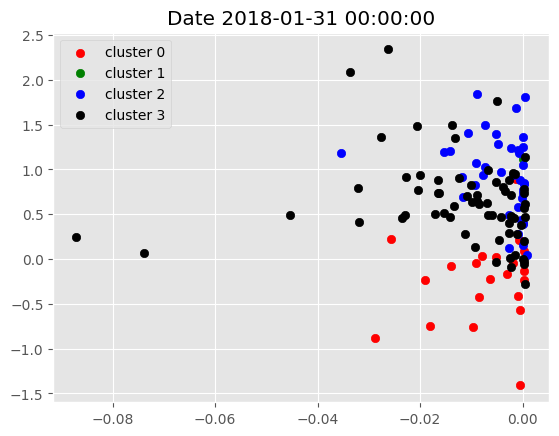

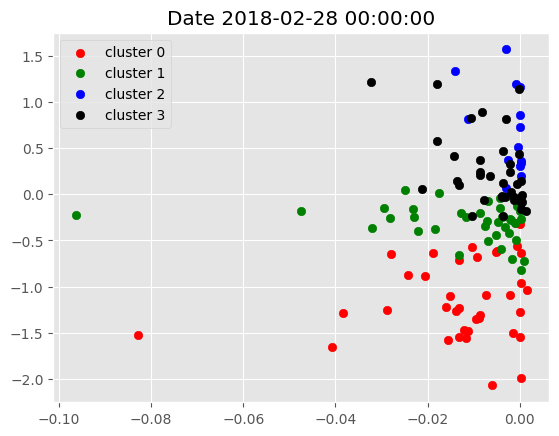

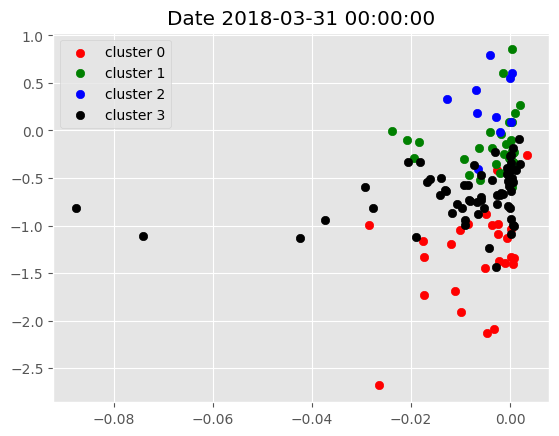

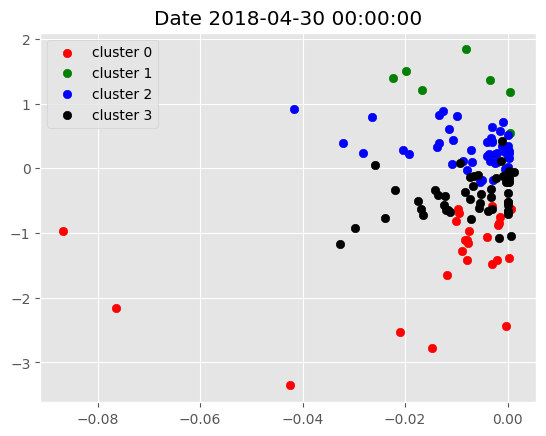

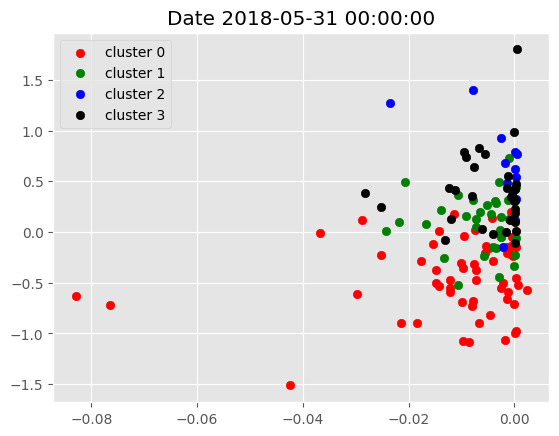

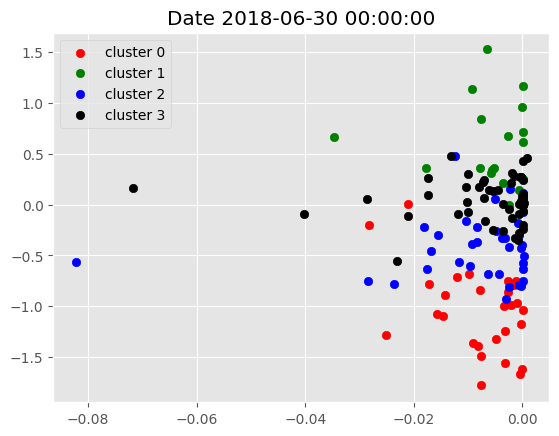

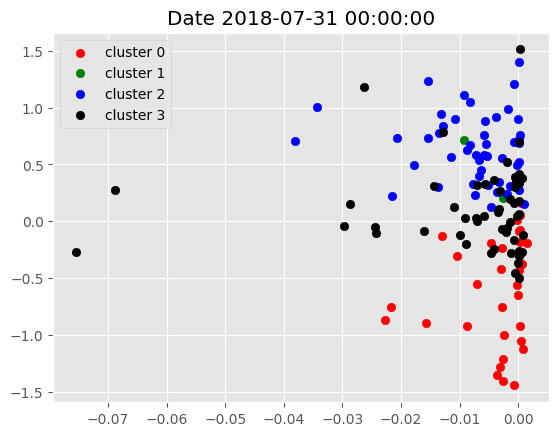

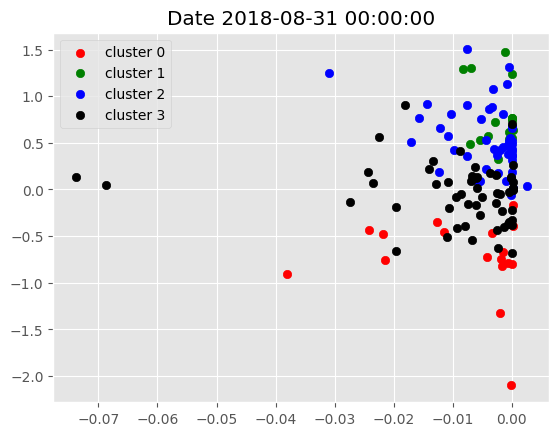

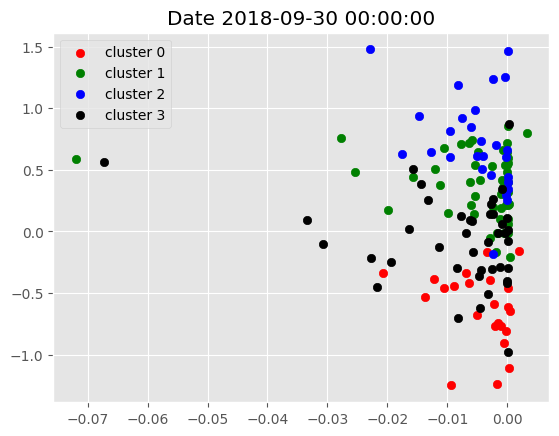

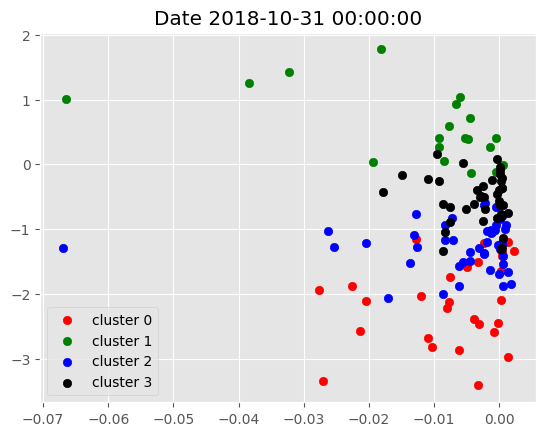

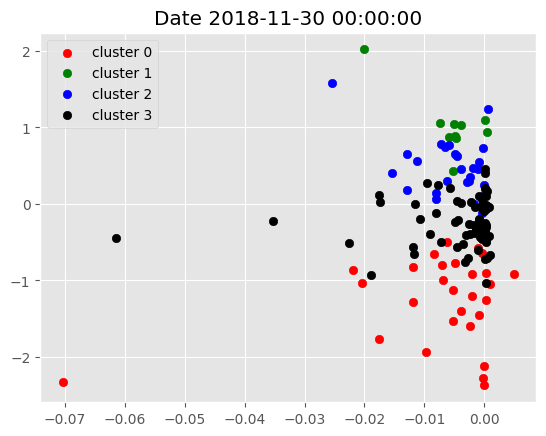

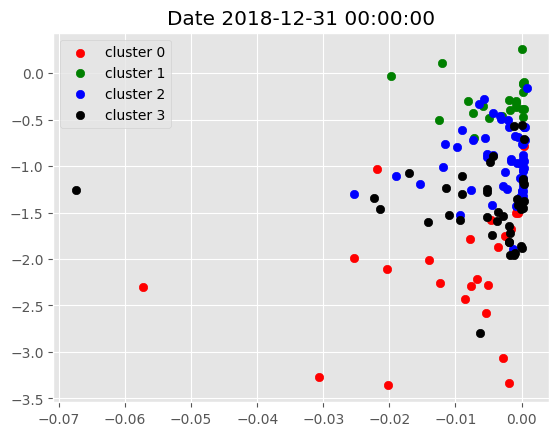

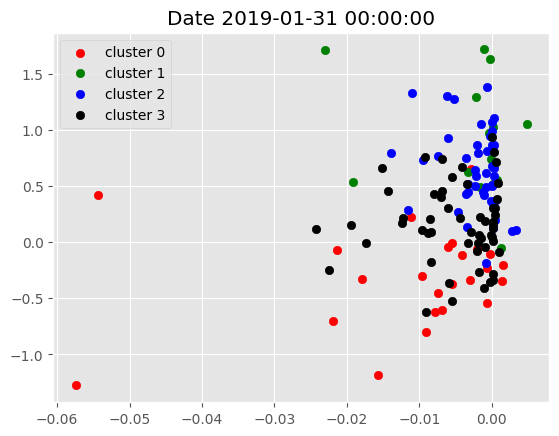

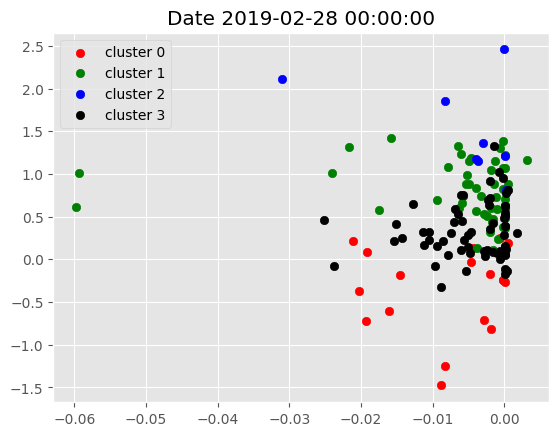

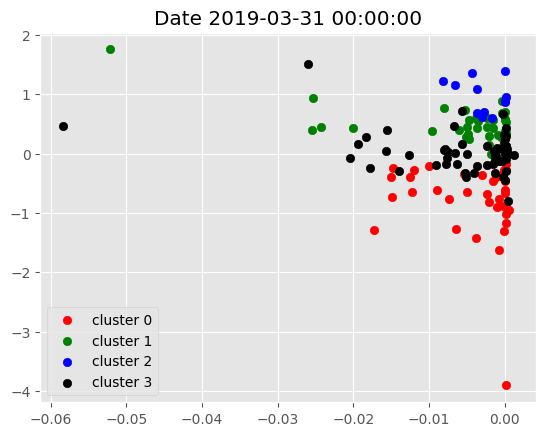

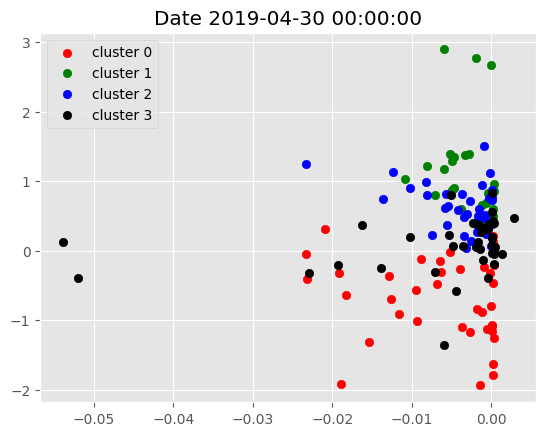

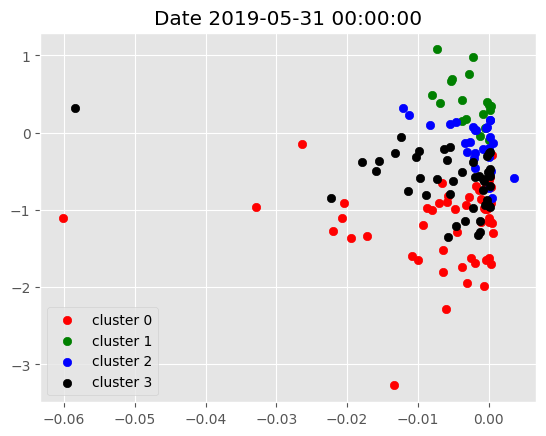

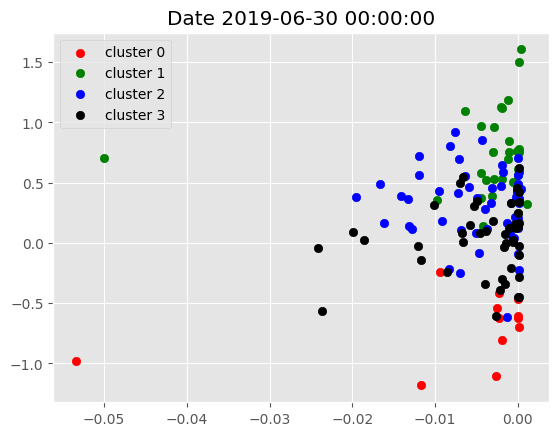

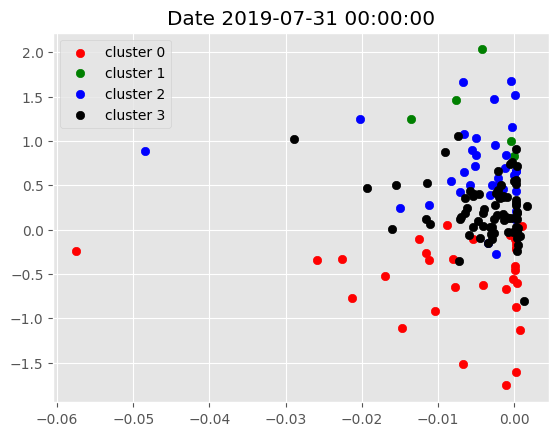

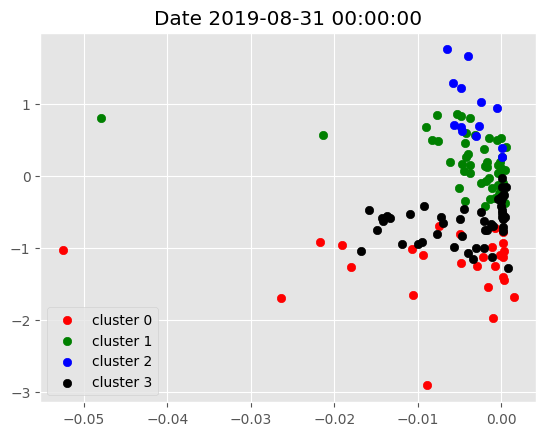

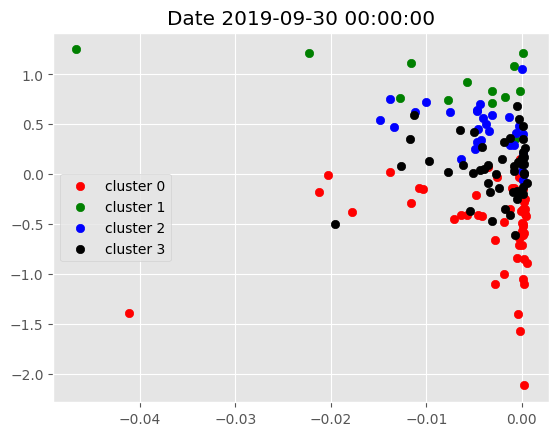

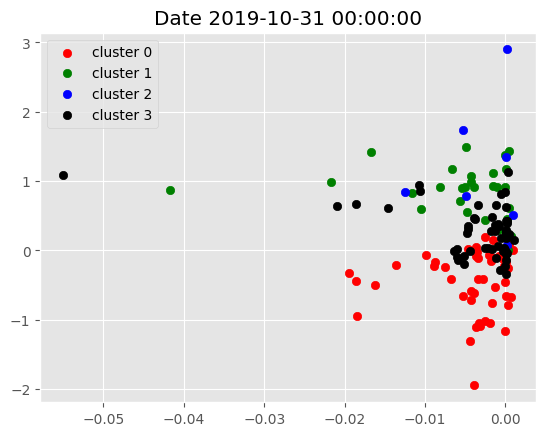

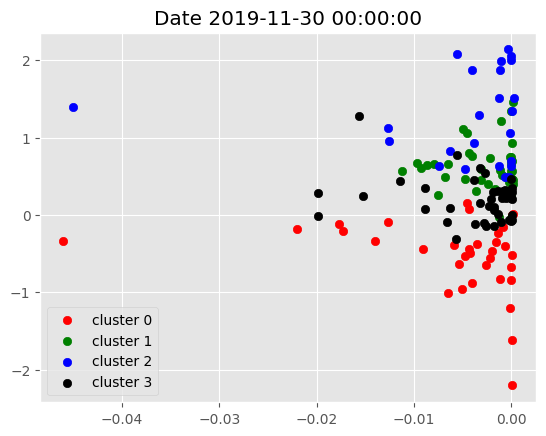

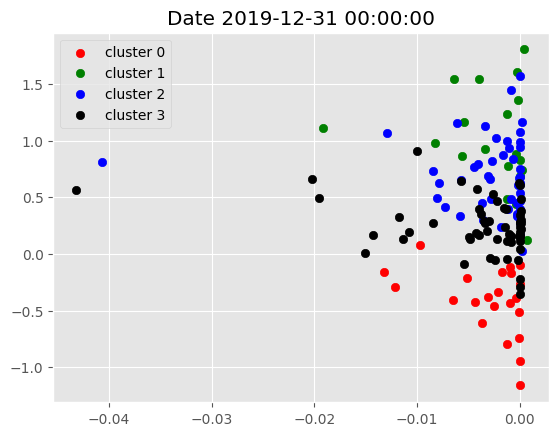

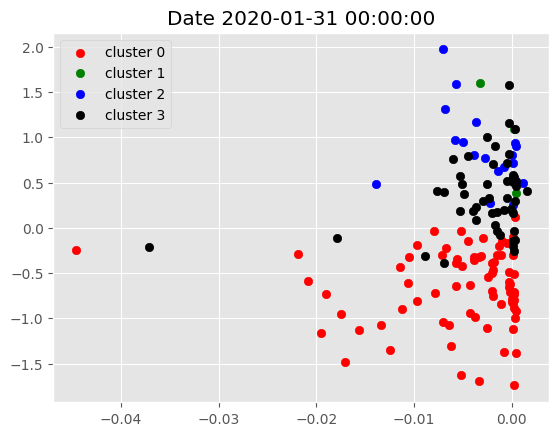

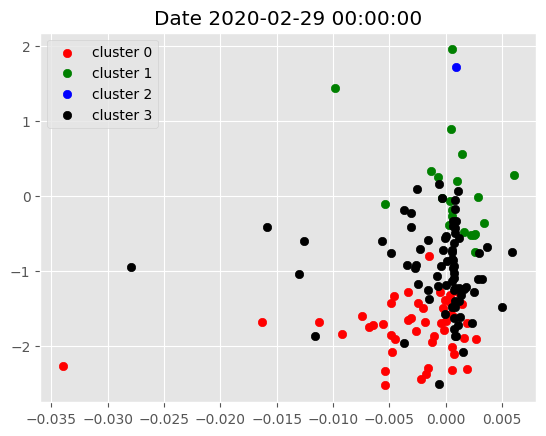

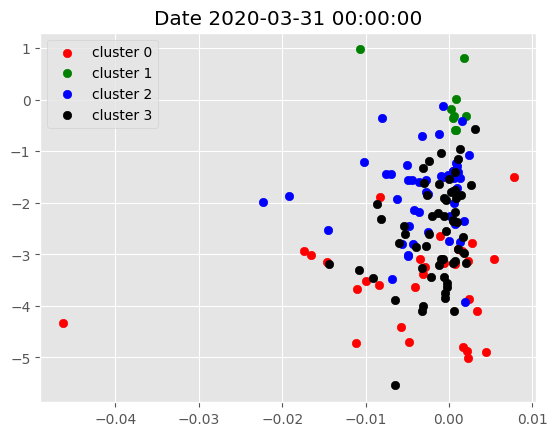

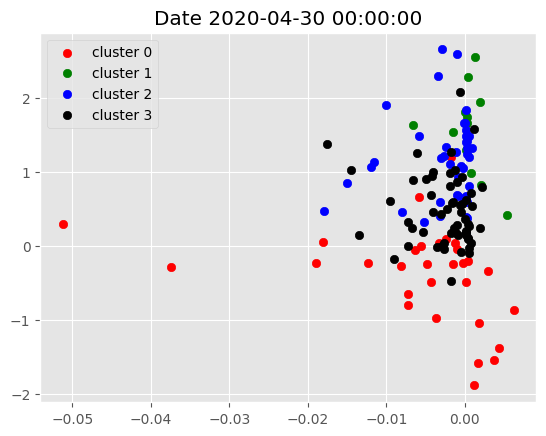

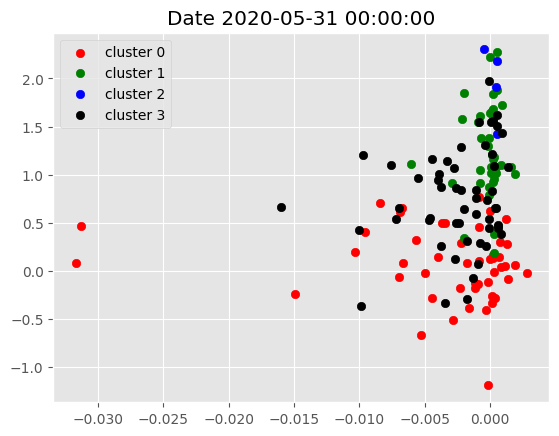

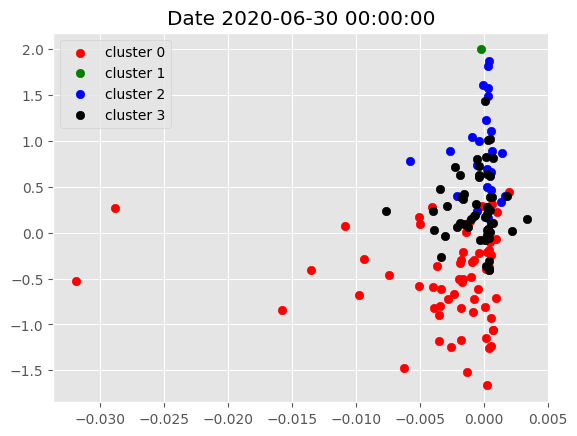

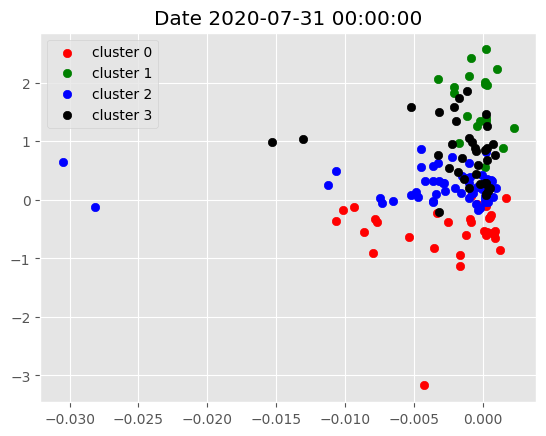

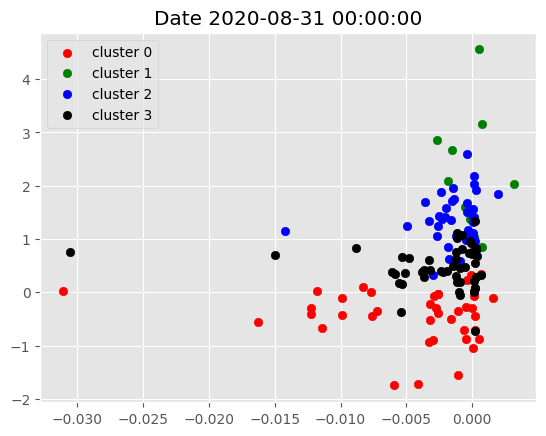

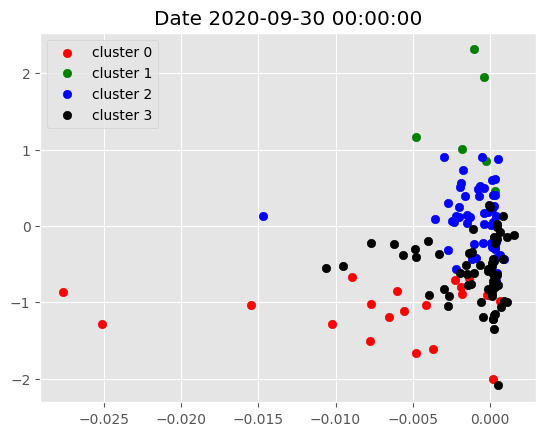

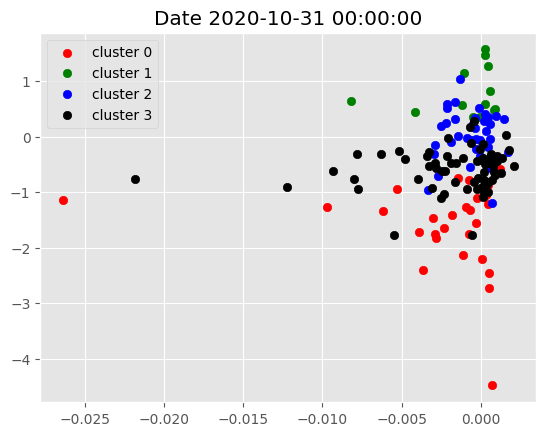

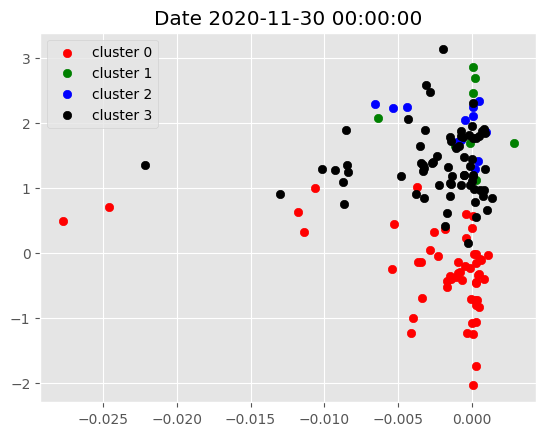

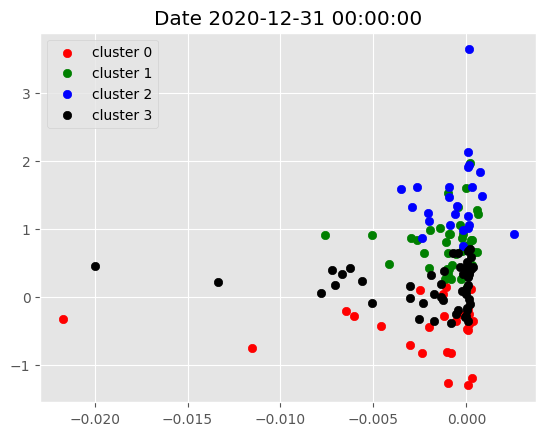

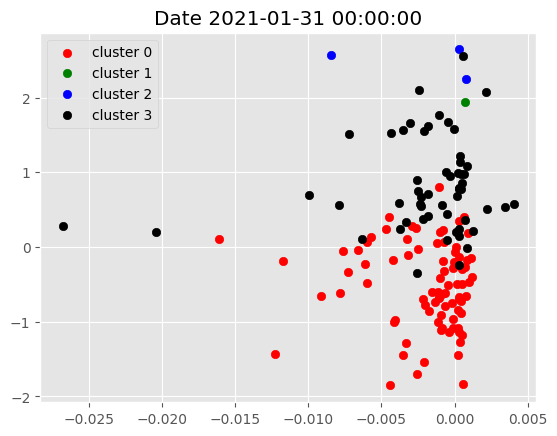

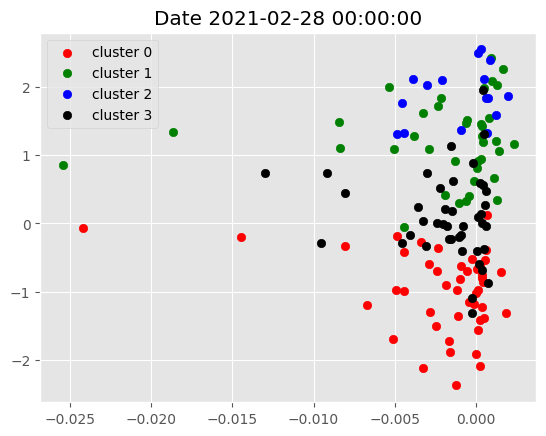

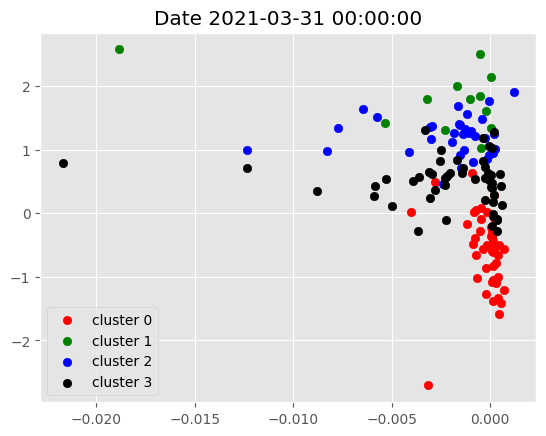

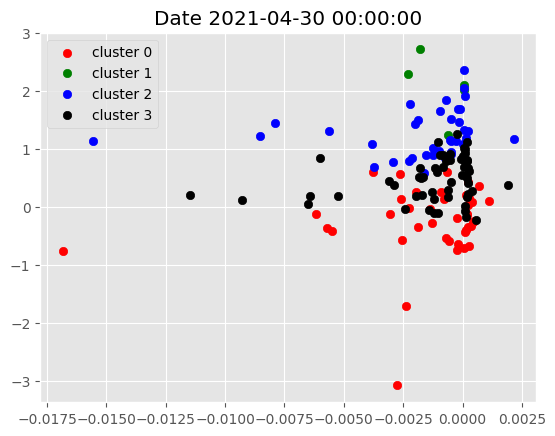

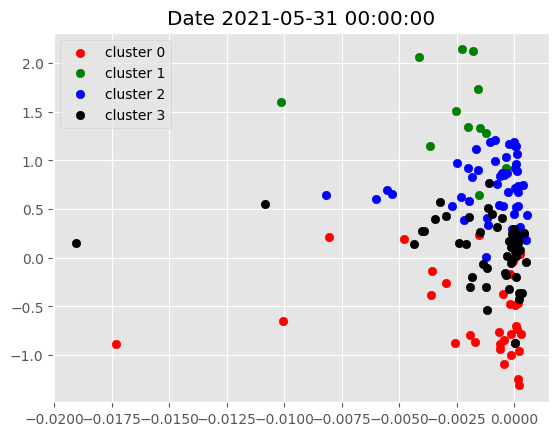

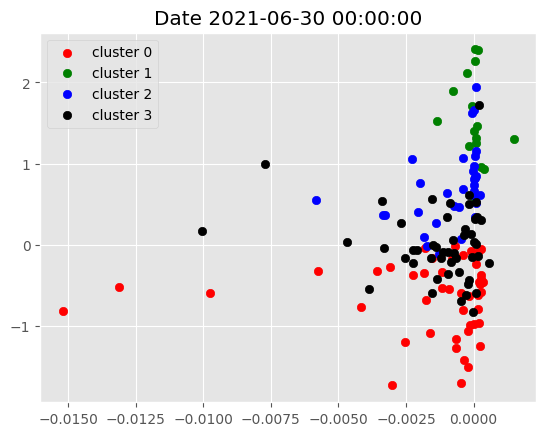

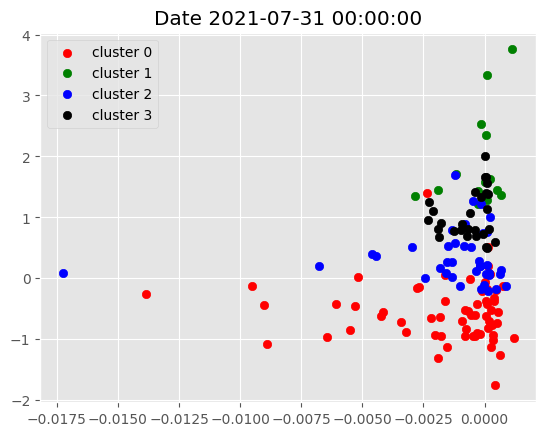

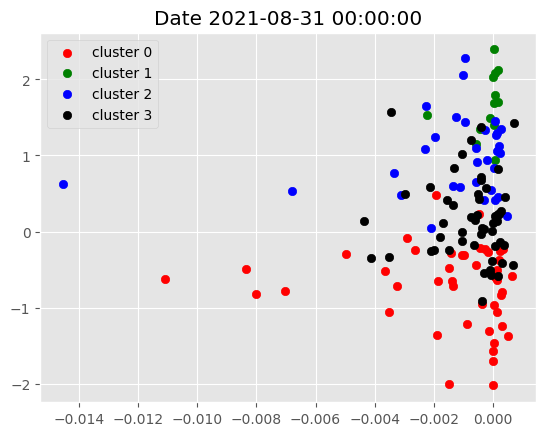

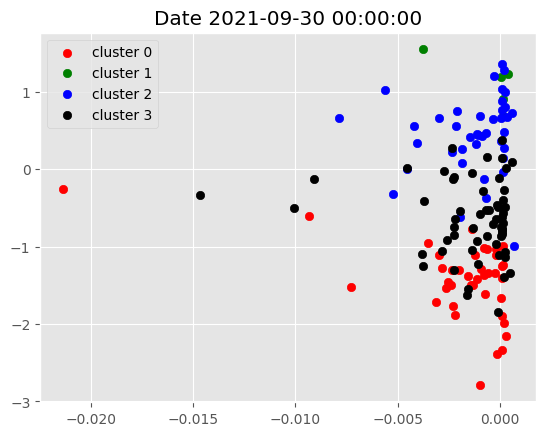

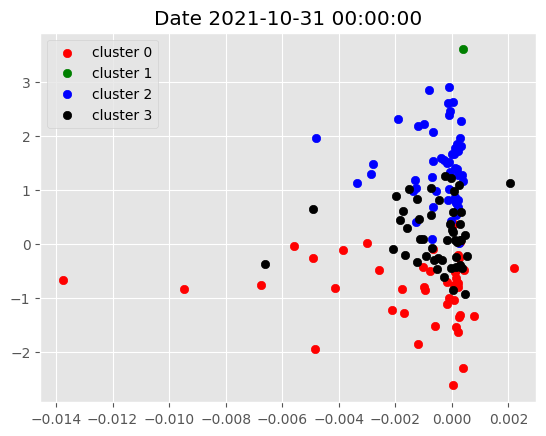

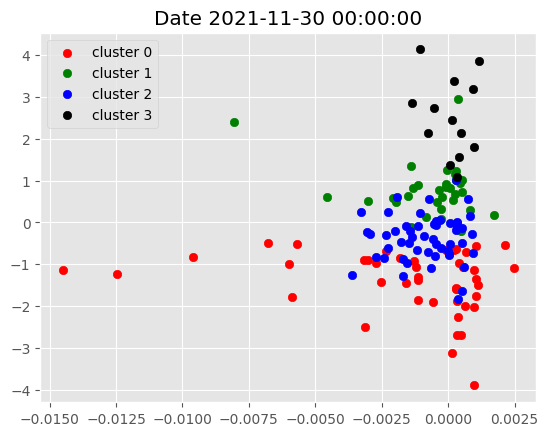

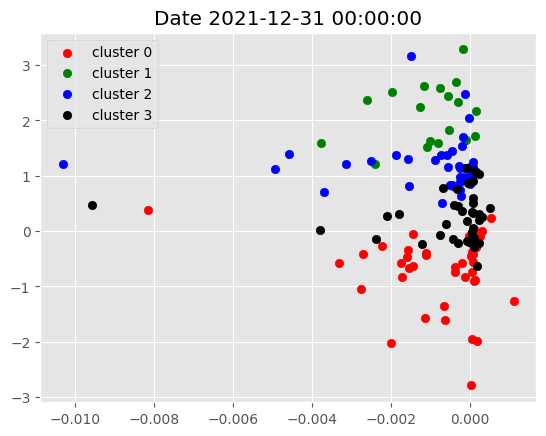

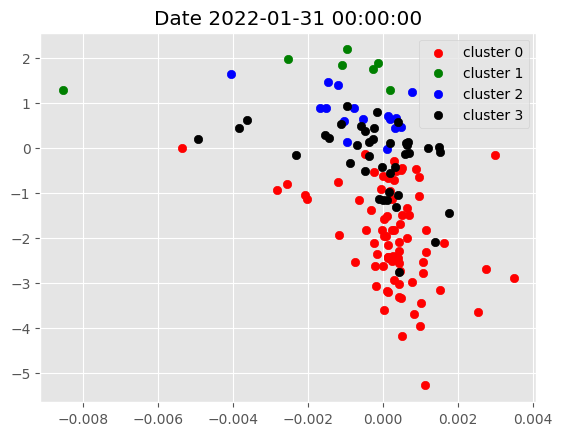

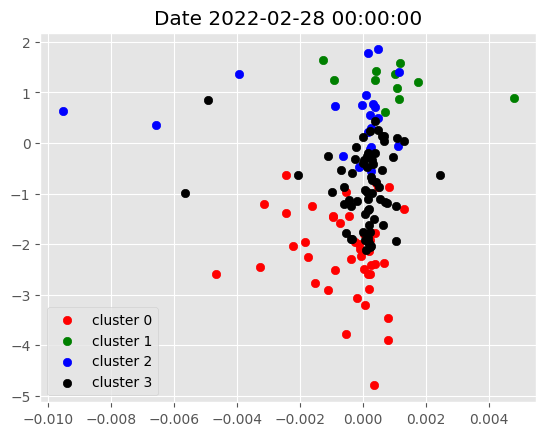

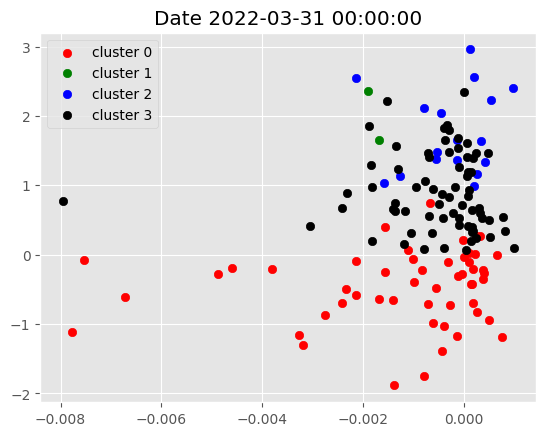

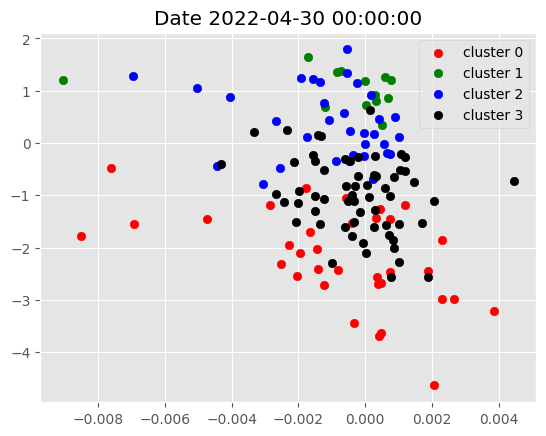

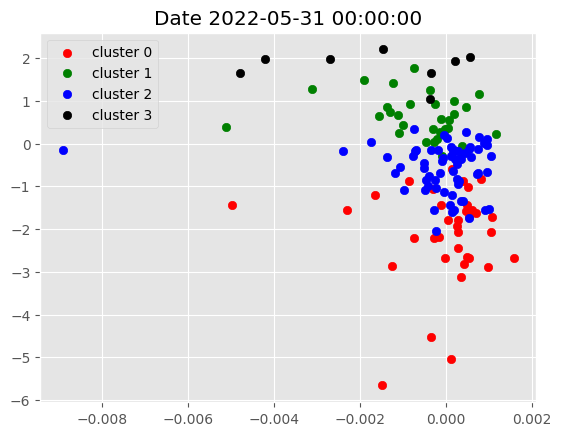

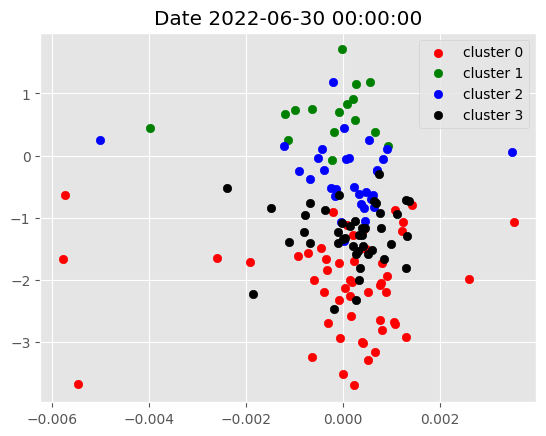

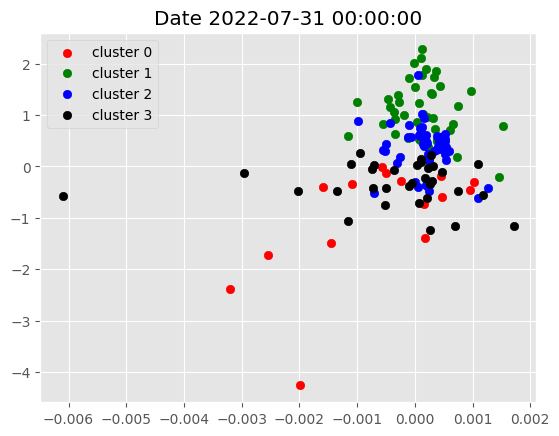

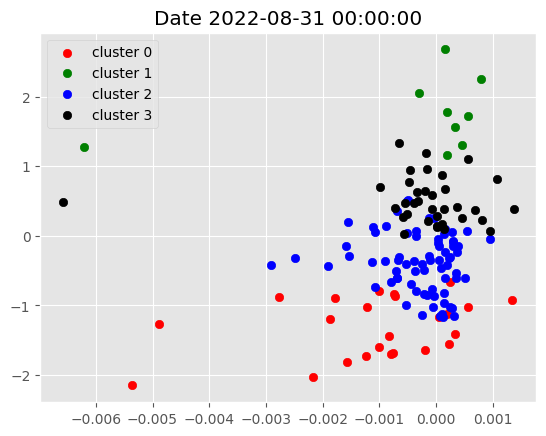

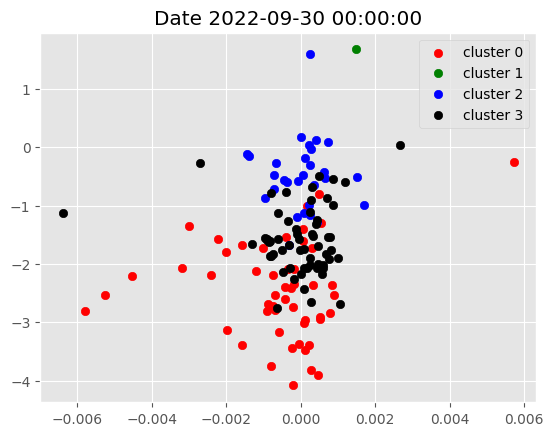

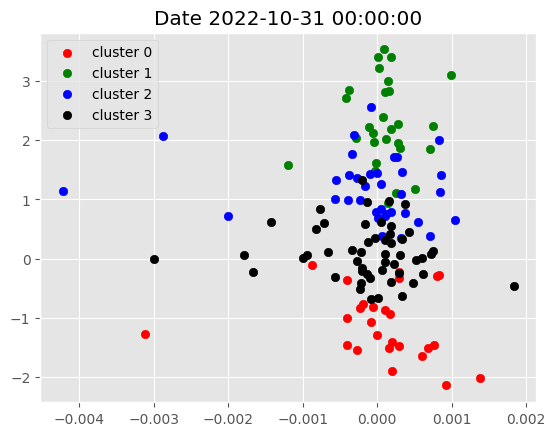

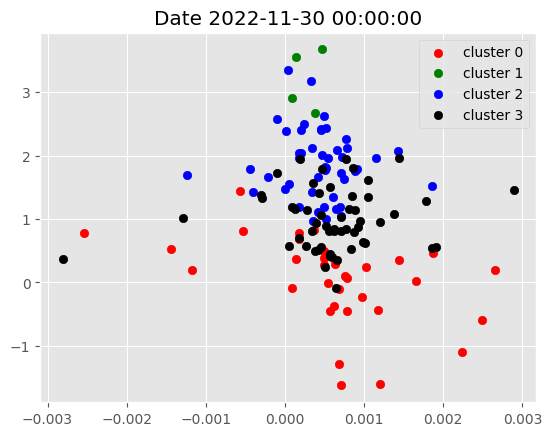

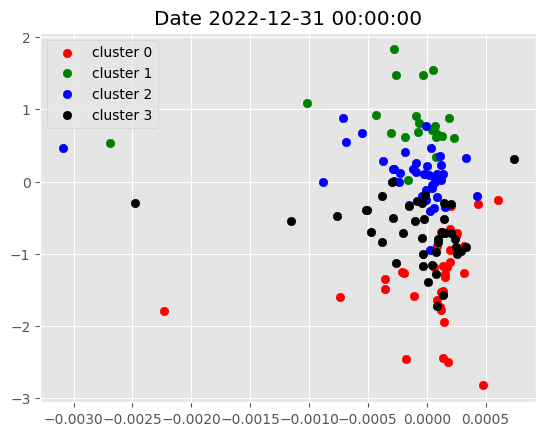

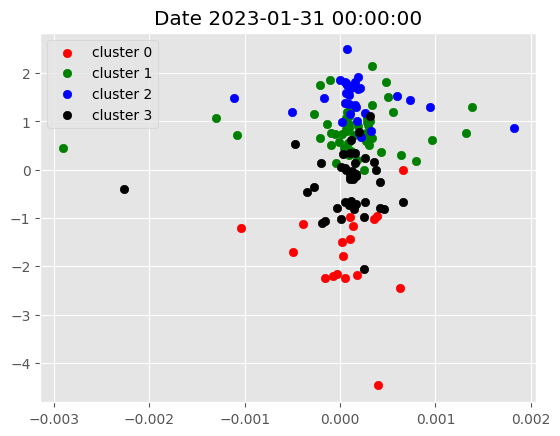

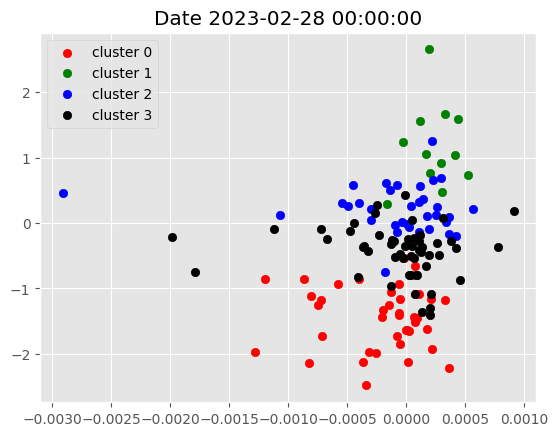

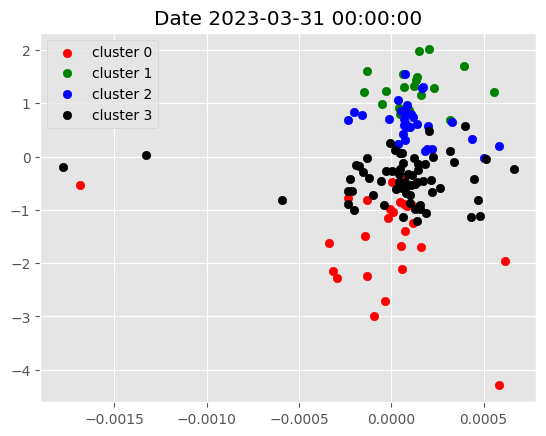

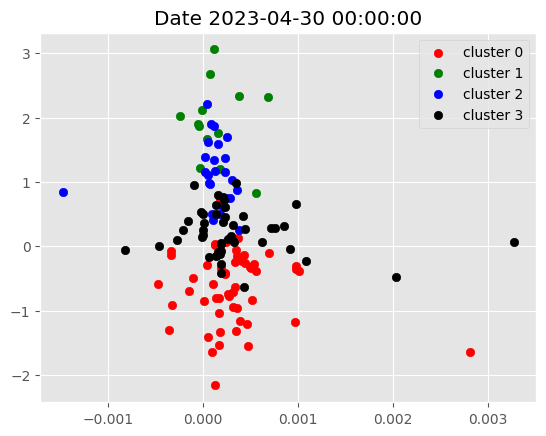

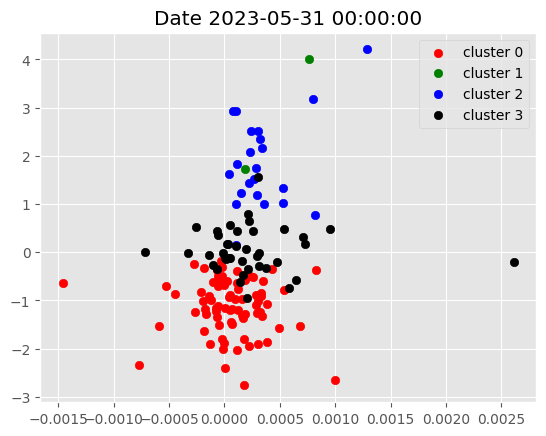

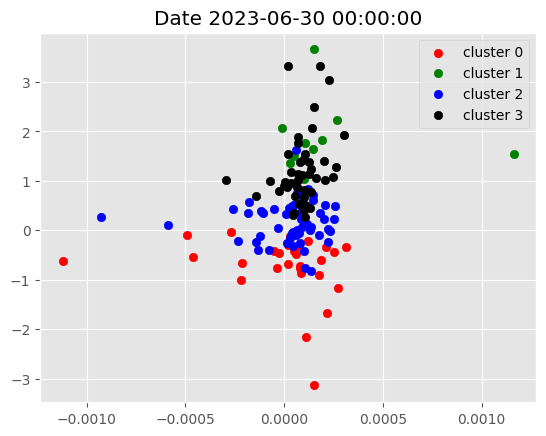

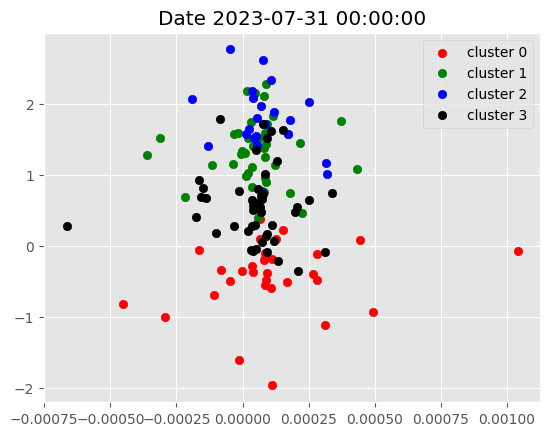

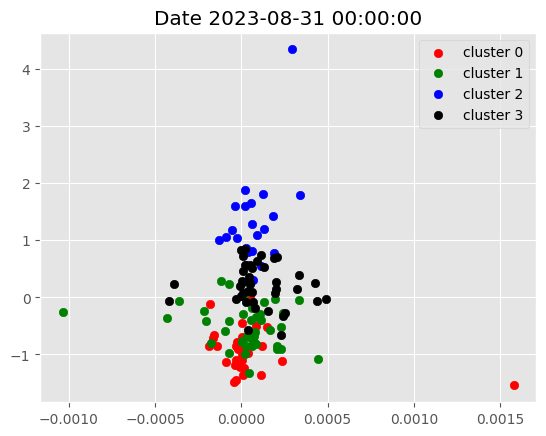

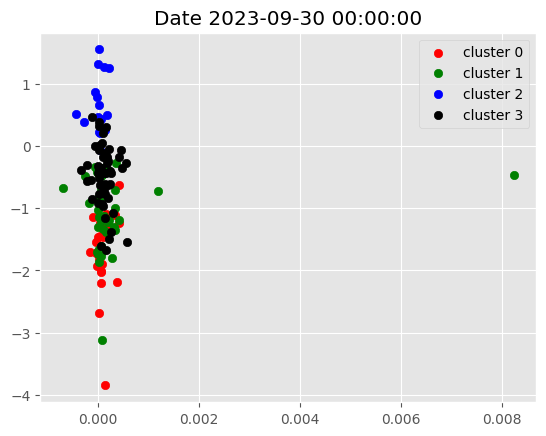

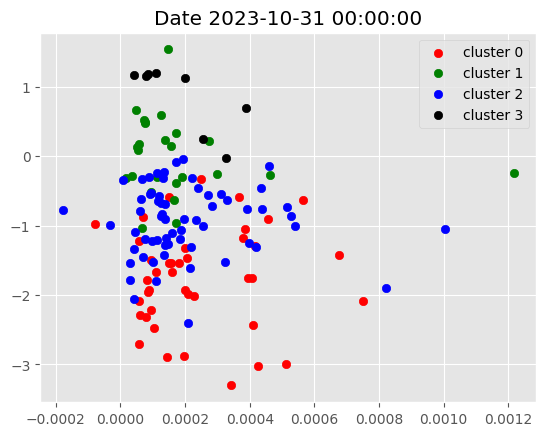

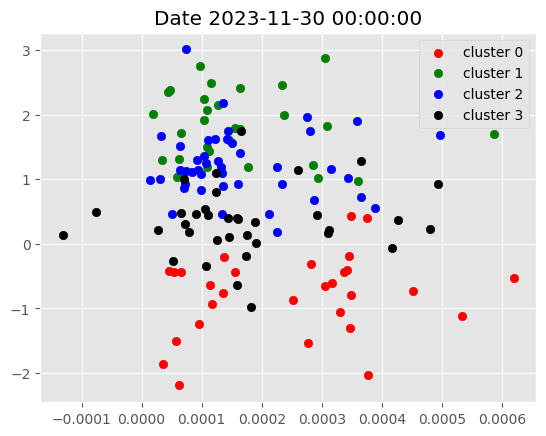

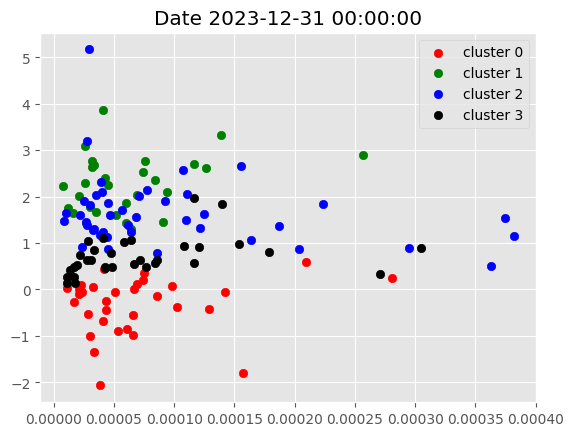

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [16]:
# Portfolio based on Efficient Frontier max sharpe ratio optimization
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-02-01': ['AAL',
  'ABBV',
  'ACN',
  'AIG',
  'AMGN',
  'AXP',
  'AZO',
  'BIIB',
  'BKNG',
  'BMY',
  'C',
  'CAT',
  'CMCSA',
  'CMG',
  'COP',
  'COST',
  'CSX',
  'CVS',
  'DAL',
  'DD',
  'DE',
  'EBAY',
  'ELV',
  'EOG',
  'EXPE',
  'FCX',
  'FDX',
  'GILD',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'INTC',
  'ISRG',
  'KO',
  'MCK',
  'MDLZ',
  'MDT',
  'META',
  'MMM',
  'MO',
  'MRK',
  'MU',
  'NEE',
  'ORCL',
  'ORLY',
  'OXY',
  'PANW',
  'PEP',
  'PFE',
  'PM',
  'PXD',
  'QCOM',
  'SCHW',
  'SHW',
  'SLB',
  'T',
  'TGT',
  'TSLA',
  'TXN',
  'UNH',
  'UPS',
  'USB',
  'VLO',
  'WBA',
  'WDC',
  'XOM'],
 '2018-03-01': ['AAL',
  'AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'AMAT',
  'AMGN',
  'BAC',
  'BMY',
  'BRK-B',
  'BSX',
  'CMG',
  'COST',
  'EA',
  'EBAY',
  'GD',
  'GS',
  'HUM',
  'ISRG',
  'JPM',
  'LMT',
  'MAR',
  'MDLZ',
  'MS',
  'MSFT',
  'NKE',
  'NVDA',
  'ORCL',
  'PFE',
  'PNC',
  'PYPL',
  'RTX',
  'SCHW',
  'TGT',
  'TSLA',
  'TXN',
  'V',
  'WDC'],
 '2018

## Portfolio optimization function

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252)
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-31  42.760239   28.233549   45.380974   37.100914  102.222740   
2017-02-01  42.566982   29.955246   45.217598   37.598309  101.630234   
2017-02-02  42.528324   29.904060   45.217598   37.971359  102.016258   
2017-02-03  42.711929   30.032034   45.054218   37.998016  102.779312   
2017-02-06  43.774891   30.313549   45.039368   37.687126  102.501015   
...               ...         ...         ...         ...         ...   
2023-12-22  14.310000  193.600006  154.940002  109.029999  354.450012   
2023-12-26  14.110000  193.050003  154.619995  109.230003  353.429993   
2023-12-27  13.990000  193.149994  154.880005  109.790001  353.820007   
2023-12-28  13.980000  193.580002  154.750000  110.400002  351.589996   
2023-12-29  13.740000  192.529999  154.970001  110.070000  350.910004   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31  113.379997   87.153641   81.339996  53.358719   31.547506  ...   
2017-02-01  113.360001   82.200066   81.279999  53.367008   32.265961  ...   
2017-02-02  113.160004   83.123497   82.760002  53.242466   32.183060  ...   
2017-02-03  115.169998   83.598137   84.410004  53.923344   32.523880  ...   
2017-02-06  114.459999   83.252930   82.820000  53.890137   32.404133  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-22  598.750000  230.970001  242.759995  66.930000  162.050003  ...   
2023-12-26  598.260010  232.539993  245.070007  67.129997  164.279999  ...   
2023-12-27  596.080017  231.610001  245.110001  67.150002  164.210007  ...   
2023-12-28  595.520020  232.490005  244.910004  67.870003  163.119995  ...   
2023-12-29  596.599976  232.970001  243.479996  67.750000  162.070007  ...   

              Volume                                                  \
                   V       VLO     VRTX        VZ       WBA      WDC   
Date                                                                   
2017-01-31   7479400  11657700  2418400  16844200   3424400  3617800   
2017-02-01   7534400   5204500  1754700  26004100   5080000  3897800   
2017-02-02  11142300   6193200  1290800  17787200   3667400  2982700   
2017-02-03  28079600   4416400  1226800  15166400   3167700  2624900   
2017-02-06   9665300   4297800  1423800  16151400   3418400  2307400   
...              ...       ...      ...       ...       ...      ...   
2023-12-22   5111500   2279000   804200  13157900   9776300  2936500   
2023-12-26   2085100   1807100   531600  11856600  10181100  2010800   
2023-12-27   4034700   1358000   594000  15267600   8265500  2167200   
2023-12-28   3020500   1661200   735600  14931700   7899900  4200000   
2023-12-29   4074600   1963400   727400  16205200  10853300  3478100   

                                                  
                 WFC      WMT     WYNN       XOM  
Date                                              
2017-01-31  22409100  9320900  1827500  19128100  
2017-02-01  21157700  9050000  3025400  15111800  
2017-02-02  13044400  8998700  1698700  12200100  
2017-02-03  19879800  7625300  1888800  12746300  
2017-02-06  13940200  9097200  2828800   9938200  
...              ...      ...      ...       ...  
2023-12-22  10448000  6467400  1170500  12921800  
2023-12-26   8856600  3893300  1150000  16835100  
2023-12-27  12536700  6632000  1142200  14558800  
2023-12-28   9872600  5592000  1233000  16329300  
2023-12-29  11731900  7314200  1144800  17741400  

[1741 rows x 936 columns]

In [19]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-02-01,0.000386
2018-02-02,-0.019579
2018-02-05,-0.039409
2018-02-06,0.014116
2018-02-07,-0.005249
...,...
2023-12-22,0.000178
2023-12-26,0.005906
2023-12-27,0.001901


In [20]:
# Visualize Portfolio returns and compare to SP500 returns
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-02-01,0.000386,-0.001136
2018-02-02,-0.019579,-0.022010
2018-02-05,-0.039409,-0.042722
2018-02-06,0.014116,0.019511
2018-02-07,-0.005249,-0.005440
...,...,...
2023-12-22,0.000178,0.002008
2023-12-26,0.005906,0.004214
2023-12-27,0.001901,0.001806
2023-12-28,0.000631,0.000378


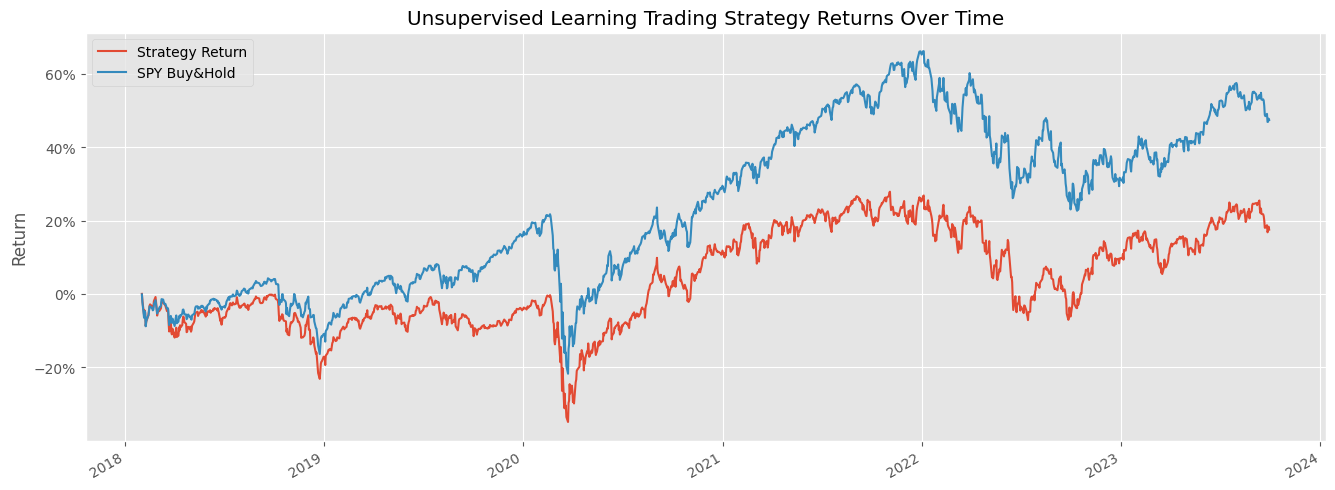

In [21]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()